In [1]:
!pip install --upgrade matplotlib
!pip install --upgrade tensorflow

In [2]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Import necessary items from Keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D, concatenate
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

## Create your model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/hesham/Baseline")

In [5]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters, # Number of filters
                  kernel_size = 3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  kernel_size = 3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = Dropout(dropout_prob)(conv)
         ### END CODE HERE
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 kernel_size = 3,    # Kernel size
                 strides= 2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, # Number of filters
                  kernel_size = 3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                  kernel_size = 3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    return conv
def create_model(input_size, n_filters=32, n_classes=1):
    """
    model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False) 
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, kernel_size= 1, padding='same')(conv9)
    ### END CODE HERE
    
    model = Model(inputs=inputs, outputs=conv10)

    return model

## Load the data

In [6]:
# Load training images
train_images_raw = pickle.load(open("full_CNN_train.p", "rb" ))

# Load image labels
labels_raw = pickle.load(open("full_CNN_labels.p", "rb" ))

# Make into arrays as the neural network wants these
train_images = np.array(train_images_raw)
labels = np.array(labels_raw)



Text(0.5, 1.0, 'Segmentation')

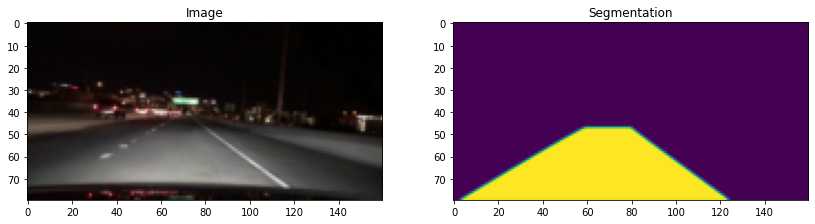

In [7]:
N = 2
#img = imageio.imread(train_images[N])
#mask = imageio.imread(labels[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(train_images[N])
arr[0].set_title('Image')
arr[1].imshow(labels[N])
arr[1].set_title('Segmentation')

## Preprocess the data

In [8]:
# TODO: Preprocess the images
datagen = ImageDataGenerator(brightness_range = (0.2,0.4),
                             height_shift_range = 0.1,
                             rotation_range = 15,
                             width_shift_range = 0.1,
                             horizontal_flip = True,
                             vertical_flip = False)

def preprocess(image, mask):
    #image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    #mask = tf.image.decode_png(mask, channels=3)
    mask = tf.round(tf.image.convert_image_dtype(mask, tf.float32))
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

Text(0.5, 1.0, 'Segmentation')

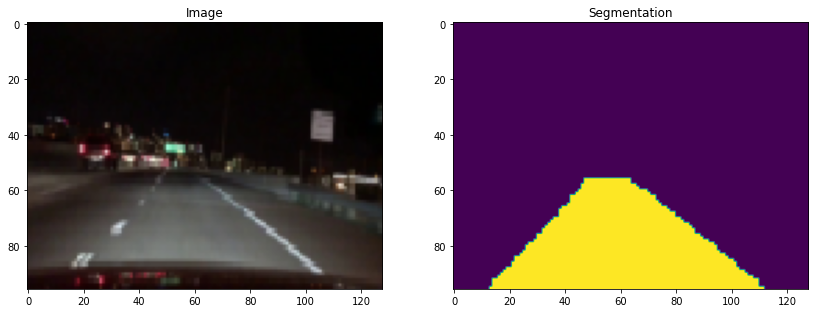

In [9]:
inp, mas = preprocess(train_images[0], labels[0])
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(inp)
arr[0].set_title('Image')
arr[1].imshow(mas)
arr[1].set_title('Segmentation')

## Create the train and test splits

In [10]:
# Shuffle images along with their labels, then split into training/validation sets
#train_images, labels = shuffle(train_images, labels)
# Test size may be 10% or 20%
# X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)
# #train_list = [train_images+i for i in X_train]
# #labels_list = [labels+i for i in y_train]
# #train_list_ds = tf.data.Dataset.list_files(train_list, shuffle=False)
# #labels_list_ds = tf.data.Dataset.list_files(labels_list, shuffle=False)
# #image_filenames = tf.constant(train_list)
# #masks_filenames = tf.constant(labels_list)
# dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(preprocess)
# processed_image_ds = dataset.map(preprocess)
# for image, mask in processed_image_ds.take(5):
#     print(mask)


## Train your model

In [11]:
lr = 3e-2
def lr_schedular(epoch):
    return lr * (0.3 **(epoch // 3))

reduce_lr = LearningRateScheduler(lr_schedular)
# Create the neural network
img_height = 96
img_width = 128
num_channels = 3
model = create_model(input_size = (img_height, img_width, num_channels))
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

In [12]:
# TODO: Train your model
EPOCHS = 7
BUFFER_SIZE = 200
BATCH_SIZE = 32
# processed_image_ds.batch(BATCH_SIZE)
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
processed_image_ds = dataset.map(preprocess)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(preprocess)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

# for images, labels in val_dataset.take(1):
#   print(images.shape)
# print(val_dataset.element_spec)
model_history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)
#model_history = model.fit_generator(generator = datagen.flow(X_train, y_train, batch_size = BATCH_SIZE), callbacks = [reduce_lr], validation_data = (X_val, y_val), epochs=EPOCHS)


Epoch 1/7
359/359 [==============================] - 36s 89ms/step - loss: 0.1029 - accuracy: 0.9635 - val_loss: 0.0248 - val_accuracy: 0.9902
Epoch 2/7
359/359 [==============================] - 26s 72ms/step - loss: 0.0241 - accuracy: 0.9902 - val_loss: 0.0204 - val_accuracy: 0.9914
Epoch 3/7
359/359 [==============================] - 26s 72ms/step - loss: 0.0211 - accuracy: 0.9912 - val_loss: 0.0189 - val_accuracy: 0.9921
Epoch 4/7
359/359 [==============================] - 26s 72ms/step - loss: 0.0207 - accuracy: 0.9915 - val_loss: 0.0209 - val_accuracy: 0.9916
Epoch 5/7
359/359 [==============================] - 26s 72ms/step - loss: 0.0187 - accuracy: 0.9922 - val_loss: 0.0160 - val_accuracy: 0.9928
Epoch 6/7
359/359 [==============================] - 26s 72ms/step - loss: 0.0149 - accuracy: 0.9934 - val_loss: 0.0147 - val_accuracy: 0.9936
Epoch 7/7
359/359 [==============================] - 26s 72ms/step - loss: 0.0138 - accuracy: 0.9938 - val_loss: 0.0139 - val_accuracy: 0.9944

## Save your model

In [13]:
# Save model architecture and weights
model.save('full_CNN_model.h5')

# Show summary of model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

In [18]:
!pip install --upgrade opencv-python

     |████████████████████████████████| 60.4 MB 57 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [48]:
!python draw_lanes.py

2022-01-09 06:44:00.751554: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
[MoviePy] >>>> Building video proj_reg_vid_2.mp4
[MoviePy] Writing video proj_reg_vid_2.mp4
100% 485/485 [00:28<00:00, 16.85it/s]
[MoviePy] Done.
[MoviePy] >>>> Video ready: proj_reg_vid_2.mp4 



In [29]:
import cv2

In [ ]:
cv2.imwrite()

In [ ]:
np.greater_equal()